In [1]:
'''
Load environment variables from a .env file
This script is used to load environment variables from a .env file
into the environment so that they can be accessed by the application.
This is useful for managing sensitive information such as API keys,
database credentials, and other configuration settings.
'''

from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
# 📦 Importing necessary libraries
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain_openai import AzureOpenAIEmbeddings
import tiktoken
import numpy as np

## 📚 Chunking
Text documents are broken into smaller, manageable chunks.

Chunking allows us to manage large documents by processing them in smaller, digestible pieces.

In [3]:
# Document
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [4]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """
    Returns the number of tokens in a text string using the specified encoding.

    Parameters:
    - string (str): The input text to be tokenized.
    - encoding_name (str): The name of the tokenizer encoding to use (e.g., 'cl100k_base').

    Returns:
    - int: Total number of tokens in the input string.
    """
    # Get the encoding method using the provided encoding name
    encoding = tiktoken.get_encoding(encoding_name)

    # Encode the string into tokens and count them
    num_tokens = len(encoding.encode(string))

    # Return the total number of tokens
    return num_tokens

# Example usage: Count tokens in a question string using the 'cl100k_base' encoding
num_tokens_from_string(question, "cl100k_base")


8

In [5]:
# Load a PDF document

loader = PyPDFLoader("sample.pdf")
documents = loader.load()

In [6]:
# ✂️ Splitting the document into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(documents)

In [7]:
# Count the number of splits
len(splits)

10

## 🧠 Embeddings
Each chunk is converted into a numerical vector representation using an embedding model.

Embeddings transform each chunk into a vector that captures its semantic meaning.

In [8]:
# 🧠 Creating vector embeddings using Azure OpenAI
embd = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_EMBEDDING_API_VERSION"],
    model="text-embedding-3-small"
    )

In [9]:
# Embedding
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)

# Embedding Dimensions
len(query_result)

1536

## 🗂️ Indexing
The document embeddings are added to a FAISS vector store for similarity-based retrieval.

These vector embeddings are indexed using FAISS, enabling efficient similarity searches later.

In [10]:
# Create FAISS index (vectorstore)
faiss_index = FAISS.from_documents(
    splits, 
    embedding=embd,
)

In [11]:
# 🔎 Performing similarity search with sample oneline query and document
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.5466795481372141


## Some Important Methods of Vector DataBase

## 🔗 Mapping Vector IDs to Original Documents

When working with vector databases (like FAISS), each embedded chunk is assigned a **vector ID**. These IDs are used internally by the vector store to perform similarity search efficiently.

However, for us to **understand what each vector actually represents**, we need to map those vector IDs back to the **original documents or text chunks**.

This mapping ensures:
- ✅ Accurate retrieval of source content
- 📎 Clear traceability from vector back to raw data
- 🧠 Human-readable context after a similarity search

In LangChain + FAISS, this is often handled using a `docstore` that links `index_to_docstore_id`, like so:


In [12]:
for i in faiss_index.index_to_docstore_id:
    print(f"Document {i}: {faiss_index.index_to_docstore_id[i]}")

Document 0: a01bcd91-8d40-4f41-a0b1-e8ead7bd53b2
Document 1: ba640c91-61f9-469b-8070-581154db1c08
Document 2: a6c217f4-eda7-470b-a21e-52405352fc30
Document 3: 2667534c-e2ab-4cd2-8277-c1ba76374a1a
Document 4: d613310d-5da5-4e9a-8b89-81234b0c685e
Document 5: e611d0de-a61f-480b-b40e-4ce1ed34d1f0
Document 6: e4bdaae4-d4a3-408c-9d78-da49a91f938f
Document 7: d9c9e61e-e95d-4111-a74e-9f26935bb7df
Document 8: 2ff04415-77d6-4663-bb78-d22a7c425faf
Document 9: b9766016-cdc7-4afb-a786-a21a0708329d


## 🗂️ Docstore in FAISS: Browsing Stored Documents

The **`docstore`** contains the actual documents or chunks stored in the FAISS vector index, each mapped by a unique ID.

This structure allows you to:
- 🔍 Manually inspect what’s inside the vector database
- 🧩 Retrieve the original text chunk using its vector ID
- 🛠️ Debug or verify the integrity of your stored data

### 🧠 How It Works:

When a document is added:
- FAISS generates a **vector ID** for each chunk
- LangChain maps this ID to the corresponding document in the `docstore`



In [13]:
for i in list(faiss_index.docstore._dict):
    print(i)
    print(f"Document {i}: {faiss_index.docstore._dict[i]}")
    print("\n")

a01bcd91-8d40-4f41-a0b1-e8ead7bd53b2
Document a01bcd91-8d40-4f41-a0b1-e8ead7bd53b2: page_content='Before using iPhone, review the iPhone User Guide  at  
support.apple.com/guide/iphone .
Safety and Handling
See “Safety, handling, and support” in the iPhone  
User Guide.
Exposure to Radio Frequency
On iPhone, go to Settings > General > Legal &  
Regulatory > RF Exposure. Or go to apple.com/ 
legal/rfexposure.
Battery and Charging
An iPhone battery should only be repaired by a trained 
technician to avoid battery damage, which could cause 
overheating, fire, or injury. Batteries should be recycled 
or disposed of separately from household waste and 
according to local environmental laws and guidelines. For 
information about Apple lithium-ion batteries and battery 
service and recycling, go to apple.com/batteries/service-
and-recycling. For information about charging, see' metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.3 (Macintosh)', 'creationdate': '2024-

## ⚙️ Accessing the Raw FAISS Index: `faiss_index.index`

The `.index` attribute gives you **direct access to the underlying FAISS index object**, bypassing high-level abstractions.

### 🔍 Why is this useful?

With `faiss_index.index`, you can:
- 🎯 Run **custom FAISS operations** (e.g., brute-force search, advanced filtering)
- 🧪 Experiment with **clustering**, **approximate nearest neighbors (ANN)**, or dimensionality reduction
- ⚡ Optimize performance or tune behavior beyond LangChain’s defaults


In [ ]:
# 🖨️ Displaying output
print(faiss_index.index.ntotal)  # Number of vectors
print(faiss_index.index.d)  # Number of dimensions

10
1536


## 🔍 Quick Retrieval: `faiss_index.similarity_search("your query", k=3)`

This method allows you to perform a **barebones similarity search** using a raw query string — without needing to set up a separate retriever object.

### 🚀 Why use this?

- ✅ Quick way to test if your FAISS index is retrieving **relevant chunks**
- 🧪 Great for debugging your embeddings or chunking strategy
- 🧱 Useful in prototyping before building a full RAG pipeline


In [15]:
results = faiss_index.similarity_search("Is it charge any international charges?", k=2)
for r in results:
    print(r.page_content)
    print("\n")


and may be restricted to the original country of sale. Call 
charges and international shipping charges may apply, 
depending on the location. Subject to the full terms and 
detailed information on obtaining service available at 
apple.com/legal/warranty  and support.apple.com , if you 
submit a valid claim under this warranty, Apple will either 
repair, replace, or refund your hardware device at its own 
discretion. Warranty benefits are in addition to rights 
provided under local consumer laws. You may be required 
to furnish proof of purchase details when making a claim 
under this warranty.
© 2024 Apple Inc. All rights reserved. Apple, the Apple 
logo, iPhone, and TrueDepth are trademarks of Apple Inc., 
registered in the U.S. and other countries and regions. 
Apple Store is a service mark of Apple Inc., registered in


Before using iPhone, review the iPhone User Guide  at  
support.apple.com/guide/iphone .
Safety and Handling
See “Safety, handling, and support” in the iPhone  
Use

## 📏 Check Similarity Scores: `similarity_search_with_score(...)`

While `similarity_search()` gives you the most relevant documents, it doesn’t tell you **how similar** those results actually are.

That’s where `similarity_search_with_score()` comes in!

### 🎯 Purpose:
- ✅ Returns both the **retrieved document chunks** and their **similarity scores**
- 🧠 Helps evaluate the quality of retrieval
- 🎛️ Useful for thresholding or filtering out weak matches



In [16]:
results = faiss_index.similarity_search_with_score("Is it charge any international charges?", k=2)
for doc, score in results:
    print(f"Score: {score:.4f} | Chunk: {doc.page_content[:100]}")

Score: 1.2915 | Chunk: and may be restricted to the original country of sale. Call 
charges and international shipping char
Score: 1.4486 | Chunk: Before using iPhone, review the iPhone User Guide  at  
support.apple.com/guide/iphone .
Safety and 


## 🧬 Visualize the Embeddings

Embeddings transform each document chunk into a **high-dimensional vector** that captures its **semantic meaning**.

To **visually explore** how your FAISS index is structured and how similar your chunks are to each other, you can reduce these embeddings to **2D** space using techniques like **PCA** or **t-SNE**.

### 🎯 Why Visualize?
- 🧠 Understand cluster formations in your data
- 🔍 Spot redundant or overlapping chunks
- 🧪 Inspect chunk separability (great for debugging)


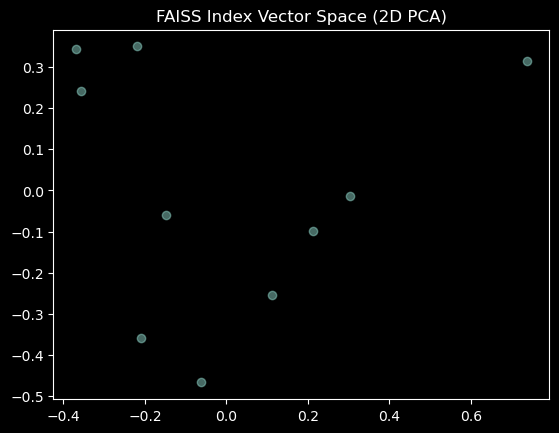

In [17]:
# 📦 Importing necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract vectors
vectors = faiss_index.index.reconstruct_n(0, faiss_index.index.ntotal)

# Reduce dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
plt.title("FAISS Index Vector Space (2D PCA)")
plt.show()


## 💾 Save & Reload the FAISS Index

If you're scaling up or working with large documents, it's important to understand **persistence** — how to save your FAISS index and reload it later without reprocessing all data.

This lets you:
- 🧠 Skip recomputing embeddings
- ⚡ Speed up prototyping and testing
- 🗃️ Maintain long-term storage of your vector database



In [18]:
# Saving FAISS index
faiss_index.save_local("my_faiss_index")

In [19]:
# 🏗️ loading FAISS vector index
new_index = FAISS.load_local("my_faiss_index", embd, allow_dangerous_deserialization=True)

results = new_index.similarity_search("Is it charge any international charges?", k=1)
for r in results:
    print(r.page_content)
    print("\n")

and may be restricted to the original country of sale. Call 
charges and international shipping charges may apply, 
depending on the location. Subject to the full terms and 
detailed information on obtaining service available at 
apple.com/legal/warranty  and support.apple.com , if you 
submit a valid claim under this warranty, Apple will either 
repair, replace, or refund your hardware device at its own 
discretion. Warranty benefits are in addition to rights 
provided under local consumer laws. You may be required 
to furnish proof of purchase details when making a claim 
under this warranty.
© 2024 Apple Inc. All rights reserved. Apple, the Apple 
logo, iPhone, and TrueDepth are trademarks of Apple Inc., 
registered in the U.S. and other countries and regions. 
Apple Store is a service mark of Apple Inc., registered in




## ➕ Add More Documents Later

Your FAISS index isn't static — you can **dynamically add new documents** at any time without needing to rebuild the entire index.

This is useful when:
- 📈 New data arrives over time (e.g., new PDFs, notes, or pages)
- 🔄 You’re iteratively building your knowledge base
- 🧪 You want to test how additional context affects retrieval

In [ ]:
# 📄 Loading new PDF document
new_loader = PyPDFLoader("<path_to_new_pdf>")
new_docs = text_splitter.split_documents(new_loader.load())
faiss_index.add_documents(new_docs)

---

<!-- Font Awesome CDN (Add in <head> if not already included) -->
<link
  rel="stylesheet" 
  href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.0/css/all.min.css"
/>

<!-- Social Footer Section -->
<div style="
  background-color:rgb(199, 195, 195);
  padding: 40px 30px;
  border-radius: 20px;
  box-shadow: 0 4px 12px rgba(0,0,0,0.08);
  font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
  font-size: 18px;
  max-width: 900px;
  margin: 60px auto 30px;
  text-align: center;
  color: #444;
">
<!-- End of Notebook Note -->
  <h2 style="margin-bottom: 10px;">📘 End of Notebook</h2>
  <p style="color: #666; font-size: 14px;">
    Thank you for exploring! Feel free to connect via the links below.
  </p>

  <!-- Social Icons -->
<div style="
  display: flex;
  gap: 25px;
  align-items: center;
  flex-wrap: wrap;
  justify-content: center;
  margin-bottom: 25px;
">
  <!-- LinkedIn -->
  <a href="https://www.linkedin.com/in/ChiragB254" target="_blank" style="text-decoration: none; color: #0077b5;">
    <i class="fab fa-linkedin fa-lg"></i> LinkedIn
  </a>

  <!-- GitHub -->
  <a href="https://github.com/ChiragB254" target="_blank" style="text-decoration: none; color: #333;">
    <i class="fab fa-github fa-lg"></i> GitHub
  </a>

  <!-- Instagram -->
  <a href="https://www.instagram.com/data.scientist_chirag" target="_blank" style="text-decoration: none; color: #E1306C;">
    <i class="fab fa-instagram fa-lg"></i> Instagram
  </a>

  <!-- Email -->
  <a href="mailto:devchirag27@gmail.com" style="text-decoration: none; color: #D44638;">
    <i class="fas fa-envelope fa-lg"></i> Email
  </a>

  <!-- X (Twitter) -->
  <a href="https://x.com/ChiragB254" target="_blank" style="text-decoration: none; color: #000;">
    <i class="fab fa-x-twitter fa-lg"></i> X.com
  </a>
  </div>

  <p style="font-size: 13px; color: black; font-style: italic; margin-top: 8px;">
    <strong>Made with ❤️ by Chirag Bansal</strong>
  </p>
</div>
